# Let's just ask Phi-Mini 3.5 what the misconception is...
### Now with MAP@25 Score estimate!

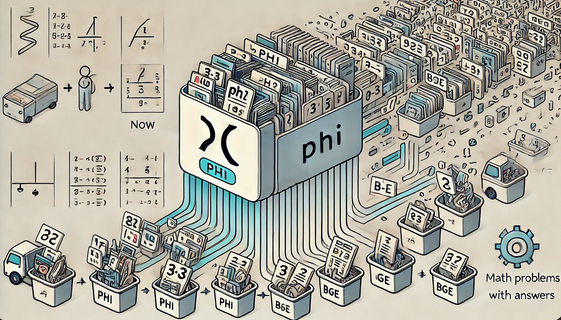

Phi-Mini is a small LLM by Microsoft we can easily run in a notebook: 
https://huggingface.co/microsoft/Phi-3.5-mini-instruct

1: Take each test question - and create a DF of similar questions that "support" it using train data.
* Consider things like "construct" and "subject"

2: For each question / answer pair in the DF - we generate a message sequence
* 3x incorrect answers per question
* Presented to the LLM as a set of questions it already answered

3: Feed those messages into Phi-Mini 3.5.  As a final message - we give it the question / answer pair we want to predict on.

4: Collect the misconceptions predictions from Phi!

5: Use BGE to generate embeddings for all misconceptions in misconception_mapping.csv

6: Use BGE to generate embeddings for LLM predicted misconceptions

7: Use cosine similariy to identify 25 closest misconceptions in misconception_mapping to the LLM prediction

## If this notebook isn't submitting for scoring - we evaluate on a subset of the train data!
* This let's us generate a MAP@25 Score estimate!

### Credit to BGE / cosine similarity code here: https://www.kaggle.com/code/pingfan/baseline-bge-cos-sim/

# Borrow some whl files to run Phi with internet off

In [ ]:
!pip install -q -U transformers --no-index --find-links /kaggle/input/hf-libraries/transformers

# Usual imports / misc.

In [ ]:
import sys 
import torch
import random
import numpy as np
import pandas as pd
import gc
import time
import random
from tqdm import tqdm

from pprint import pprint
from IPython.display import display

from sklearn.metrics.pairwise import cosine_similarity

from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM, AutoModel

if (not torch.cuda.is_available()): print("Sorry - GPU required!")
    
import logging
logging.getLogger('transformers').setLevel(logging.ERROR)

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)

# A few configuration things...

In [ ]:
# min / max example questions for prompt generation
# for each question all answers with non-NAN misconceptions will be used
min_example_questions = 5
max_example_questions = 8

#example question messages limited to this many words
#assures we don't run out of GPU RAM (if notebook throws exception - try reducing...)
max_words_for_examples = 1400

#maximum new tokens Phi will generate for responses
max_new_tokens = 55

#causes us to do evaluation on the training data instead of test stub if we aren't scoring
eval_on_train_if_not_scoring = True

#how many train questions to use when swapping in train for test (MAP@25 score estimate)
#100 questions takes about 30 minutes (more questions = better scoring estimate)
questions_for_train_eval = 100 

# Load BGE
* We'll use this later for cosine similarity

In [ ]:
device = "cuda:0"

bge_tokenizer = AutoTokenizer.from_pretrained('/kaggle/input/bge-large-en-v1.5/transformers/default/1/bge-large-en-v1.5')
bge_model = AutoModel.from_pretrained('/kaggle/input/bge-large-en-v1.5/transformers/default/1/bge-large-en-v1.5')
bge_model.eval()
bge_model.to(device)
print("BGE Loaded!")

# Load up Phi Mini!
* We try to clean up before loading this cell - but if you re-run - you might run out of GPU memory...

In [ ]:
# Clear GPU memory and delete existing objects if they exist
if torch.cuda.is_available():
    torch.cuda.empty_cache()
for obj in ['model', 'pipe', 'tokenizer']:
    if obj in globals():
        del globals()[obj]

# Model configuration
model_name = '/kaggle/input/phi-3.5-mini-instruct/pytorch/default/1'

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Load model
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16,
    device_map="auto",
    trust_remote_code=True
)

# Create pipeline
pipe = pipeline("text-generation", model=model, tokenizer=tokenizer, trust_remote_code=True, max_new_tokens=max_new_tokens)

# Test out Phi

In [ ]:
messages = [
    {"role": "user", "content": "Tell me about your math skills."},
]

pipe(messages)

# Look at Misconception Map

In [ ]:
misc_map_df = pd.read_csv("/kaggle/input/eedi-mining-misconceptions-in-mathematics/misconception_mapping.csv")
misc_map_df.head(10)

# Look at Train

In [ ]:
train_df = pd.read_csv("/kaggle/input/eedi-mining-misconceptions-in-mathematics/train.csv")
train_df.head(10)

# Look at Test
* Also figure out if this notebook is currently being submitted for scoring

In [ ]:
#assume we are scoring
scoring = True
test_df = pd.read_csv("/kaggle/input/eedi-mining-misconceptions-in-mathematics/test.csv")

#if it's just the test stub - then we aren't scoring...
if len(test_df) < 10:
    scoring = False

test_df.head(10)

# If not scoring - actually do evaluation on a subset of Train instead of Test placeholder
* So we can create a MAP@25 Score estimate (since we have answers)
* We avoid data leakage by just not including the question being evaluated in the LLM example questions

In [ ]:
evaluating_on_train = False

#set evaluating_on_train to True / swap in train for test
if scoring == False and eval_on_train_if_not_scoring:
    evaluating_on_train = True
    print("Doing evaluation / scoring on the train data")
    test_df = train_df.head(questions_for_train_eval)

# Generate a DF optimized for use as LLM prompting text for given input question
* Generates messages for with requested number of questions (each question will have multiple answers...)
* Prioritizes questions with requested construct
* Secondarily, prioritizes questions with requested subject
* If more questions are still needed - chosen at random

In [ ]:
def generate_filtered_df(df, question, min_rows=5, max_rows=10, verbose=False, random_seed=42):
    # Set the random seed for numpy and pandas
    np.random.seed(random_seed)
    
    result_df = pd.DataFrame()
    construct_count = 0
    subject_count = 0
    random_count = 0
    
    question_id = question["QuestionId"]
    subject_id = question["SubjectId"]
    construct_id = question["ConstructId"]
    
    #don't include own question in DF (only really matters if testing on train)
    df = df[df['QuestionId'] != question_id]
    
    construct_df = df[df['ConstructId'] == construct_id]
    result_df = pd.concat([result_df, construct_df])
    construct_count = len(result_df)
    if verbose: print(f"Matched ConstructId {construct_id}: {construct_count} rows")
    
    # Step 2: If we don't have enough rows, add rows with the specified SubjectId
    if len(result_df) < min_rows:
        subject_df = df[(df['SubjectId'] == subject_id) & ~df.index.isin(result_df.index)]
        rows_to_add = min(len(subject_df), min_rows - len(result_df))
        result_df = pd.concat([result_df, subject_df.head(rows_to_add)])  # Use head() instead of sample()
        subject_count = len(result_df) - construct_count
        if verbose: print(f"Added rows from SubjectId {subject_id}: {subject_count} rows")
    
    # Step 3: If we still don't have enough rows, add random rows
    if len(result_df) < min_rows:
        remaining_df = df[~df.index.isin(result_df.index)]
        rows_to_add = min(len(remaining_df), min_rows - len(result_df))
        result_df = pd.concat([result_df, remaining_df.head(rows_to_add)])  # Use head() instead of sample()
        random_count = len(result_df) - (construct_count + subject_count)
        if verbose: print(f"Added random rows to meet minimum: {random_count} rows")
    
    # Step 4: If we have more than max_rows, use the first max_rows
    if len(result_df) > max_rows:
        result_df = result_df.head(max_rows)
        if verbose: print(f"Reduced to maximum: {max_rows} rows")
    
    if verbose: 
        print(f"\nFinal DataFrame composition:")
        print(f"ConstructId matches: {construct_count}")
        print(f"SubjectId matches: {subject_count}")
        print(f"Random additions: {random_count}")
        print(f"Total rows: {len(result_df)}")
    
    return result_df.reset_index(drop=True)

# Usage
test_question = train_df.iloc[38]
filtered_df = generate_filtered_df(train_df, test_question, min_rows=min_example_questions, max_rows=max_example_questions, verbose=True, random_seed=42)
filtered_df.head(10)

# Generate array of training message segments for a given DF
## For each question / answer pair (with non-nan misconception) in DF includes:
* Question (combines ConstructName and QuestionText)
* Correct Answer
* Incorrect Answer (test question)
* Misconception for given answer

Also - size of returned data is limitted by bytes.  Intent is to assure we don't blow-up memory usage.

In [ ]:
def get_train_messages_for_df(filtered_train_df, skip_nan_misconceptions=True, answers=['A', 'B', 'C', 'D'], verbose = False):
    messages = []
    current_size = 0
    
    for _, row in filtered_train_df.iterrows():
        for answer_choice in answers:
            if answer_choice == row['CorrectAnswer']:
                continue
            
            misconception_id = row[f'Misconception{answer_choice}Id']
            
            if pd.isna(misconception_id) and skip_nan_misconceptions:
                continue
            
            if not pd.isna(misconception_id):
                new_message = [
                    f"{row['ConstructName']}: {row['QuestionText']}",
                    row[f'Answer{row["CorrectAnswer"]}Text'],
                    row[f'Answer{answer_choice}Text'],
                    misc_map_df.loc[int(misconception_id), 'MisconceptionName']
                ]
                
                # Calculate size of new message
                new_message_size = sum(sys.getsizeof(item) for item in new_message)
                                
                messages.append(new_message)
                current_size += new_message_size
            
    # Print size of returned data
    if verbose: print(f"Size of returned data: {current_size} bytes")
    
    return messages

example_sequences = get_train_messages_for_df(filtered_df, verbose = True)
example_sequences

# Define prompt components
* Tell the LLM what we are looking for
* Prefixes added to messages

In [ ]:
#original text prefix
question_prefix = "Question:"

#LLM "response"
llm_correct_response_for_rewrite = "Provide me with the correct answer for a baseline."
llm_incorrect_response_for_rewrite = "Now - provide the incorrect answer and I will anaylze the difference to infer the misconception."

#modified text prefix
incorrect_answer_prefix = "Incorrect Answer:"
correct_answer_prefix = "Correct Answer:"

#providing this as the start of the response helps keep things relevant
response_start = "Misconception for incorrect answer: "

# Cleans LLM output
* Trims down message sequence to just the LLM's response / removes response_start

In [ ]:
def clean_response(my_string, response_start):
    # Trim leading spaces first
    my_string = my_string.lstrip()
    
    # Remove response_start if present
    if my_string.startswith(response_start):
        my_string = my_string[len(response_start):]
    
    # Find indices of first period and first linefeed
    period_index = my_string.find('.')
    linefeed_index = my_string.find('\n')
    
    # Determine where to truncate
    truncate_index = len(my_string)  # Default to end of string
    if period_index != -1:
        truncate_index = period_index
    if linefeed_index != -1 and linefeed_index < truncate_index:
        truncate_index = linefeed_index
    
    # Truncate the string
    my_string = my_string[:truncate_index]
    
    return my_string.strip()

# Detection logic
* Takes input of question, answer and example message segments
* Generates actual messages for LLM
* Output is predicted misconception!

In [ ]:
def predict_misconception(question, question_letter_to_test, example_sequences, max_word_count=max_words_for_examples, verbose=False):
    correct_question_letter = question["CorrectAnswer"]
    question_text = f"{question['ConstructName']}: \n {question['QuestionText']}\n"
    correct_answer_text = question[f"Answer{correct_question_letter}Text"]
    incorrect_answer_text = question[f"Answer{question_letter_to_test}Text"]
    if correct_question_letter == question_letter_to_test:
        print("WARNING: Tested letter is for a correct answer!")

    def calculate_word_count(text):
        return len(text.split())

    # Construct the actual prompt messages
    actual_prompt_messages = [
        {"role": "user", "content": f"{question_prefix} {question_text}"},
        {"role": "assistant", "content": llm_correct_response_for_rewrite},
        {"role": "user", "content": f"{correct_answer_prefix} {correct_answer_text}"},
        {"role": "assistant", "content": llm_incorrect_response_for_rewrite},
        {"role": "user", "content": f"{incorrect_answer_prefix} {incorrect_answer_text}"}
    ]

    # Calculate the word count of actual prompt messages
    actual_prompt_word_count = sum(calculate_word_count(msg["content"]) for msg in actual_prompt_messages)

    # Construct example messages, stopping if we reach the word limit
    example_messages = []
    current_word_count = actual_prompt_word_count

    for examp_question, examp_correct_answer, examp_incorrect_answer, examp_misconception in example_sequences:
        example_set = [
            {"role": "user", "content": f"{question_prefix} {examp_question}"},
            {"role": "assistant", "content": llm_correct_response_for_rewrite},
            {"role": "user", "content": f"{correct_answer_prefix} {examp_correct_answer}"},
            {"role": "assistant", "content": llm_incorrect_response_for_rewrite},
            {"role": "user", "content": f"{incorrect_answer_prefix} {examp_incorrect_answer}"},
            {"role": "assistant", "content": f"{response_start} {examp_misconception}"}
        ]
        
        example_set_word_count = sum(calculate_word_count(msg["content"]) for msg in example_set)
        
        if current_word_count + example_set_word_count > max_word_count:
            if verbose: print("Word count limit reached.")
            break  # Stop adding new example sets if we would exceed the limit
        
        example_messages.extend(example_set)
        current_word_count += example_set_word_count

    # Combine example messages and actual prompt messages
    messages = example_messages + actual_prompt_messages

    if verbose:
        print("Example Messages:")
        for message in example_messages:
            display(message)
        print("\nActual Prompt Messages:")
        for message in actual_prompt_messages:
            display(message)
        print(f"\nTotal word count: {current_word_count}")

    decoded = pipe(messages)
    return decoded

# Hard coded test of everything...
* Using a train question so we can compare the predicted misconception with the actual one.

In [ ]:
sample_question_index = 35
question_letter_to_test = "B"

question = train_df.iloc[sample_question_index]
    
misconception_id = question[f"Misconception{question_letter_to_test}Id"]
if pd.isna(misconception_id):
    print("Error: No misconception (can't test against correct answer)")
    
misconception_text = misc_map_df['MisconceptionName'].values[int(misconception_id)]

filtered_df = generate_filtered_df(train_df, question, min_rows=5, max_rows=7)
example_sequences = get_train_messages_for_df(filtered_df)

response = predict_misconception(question, question_letter_to_test, example_sequences, verbose = True)

just_response = clean_response(response[0]['generated_text'][-1]['content'], response_start)

print ("\nPredicted Misconception:\n", just_response, "\n")
print ("Actual Misconception:\n", misconception_text)

# Generate Misconceptions for all Test
* Cycle through all non-correct answers in Test
* We are generating novel text - not trying to match with actual provided options
* If we are evaluating train data - we also create a TrainMiscId that includes the actual misconception ID (we use this later for scoring)

In [ ]:
def process_test_questions(df):
    results = []
    start_time = time.time()
    total_items = 0
    
    for question_index in range(len(df)):
        question = df.iloc[question_index]
        correct_answer = question["CorrectAnswer"]
        question_id = question["QuestionId"]
        for answer_choice in ['A', 'B', 'C', 'D']:
            #skip correct answer
            if answer_choice != correct_answer:
                filtered_df = generate_filtered_df(train_df, question, min_rows=min_example_questions, max_rows=max_example_questions)
                example_sequences = get_train_messages_for_df(filtered_df)
                response = predict_misconception(question, answer_choice, example_sequences, verbose = False)

                just_response = clean_response(response[0]['generated_text'][-1]['content'], response_start)

                result = {
                    'QuestionId_Answer': f"{question_id}_{answer_choice}",
                    'MiscPredText': just_response
                }
                
                if evaluating_on_train:
                    misc_id_column = f"Misconception{answer_choice}Id"
                    if misc_id_column in question:
                        try:
                            misc_id = int(question[misc_id_column])
                            result['TrainMiscId'] = misc_id
                        except (ValueError, TypeError):
                            #misconception missing for correct answer
                            result['TrainMiscId'] = None
                    else:
                        result['TrainMiscId'] = None
                        print(f"Warning: {misc_id_column} not found for question {question_id}")
                
                results.append(result)
                
                total_items += 1
                print(".", end="", flush=True)
    
    end_time = time.time()
    total_time = end_time - start_time
    avg_time_per_item = total_time / total_items if total_items > 0 else 0
    
    print(f"\nTotal execution time: {total_time:.2f} seconds")
    print(f"Total items processed: {total_items}")
    print(f"Average time per item: {avg_time_per_item:.2f} seconds")
    print(f"Time for 1000 questions * 3 incorrect answers (3000 items): {(avg_time_per_item * 3000) / 3600} hours")
    return pd.DataFrame(results)

# Example usage:
predicted_misc = process_test_questions(test_df)
predicted_misc

# Use BGE to get embeddings for all possible misconceptions in misconception_mapping.csv
* This only takes about 4 seconds on GPU for 2586 possible misconceptions
* This suggests that mapping the ~3000 questions / answer pairs will also take an acceptable amount of time
#### Credit to BGE / cosine similarity code here:
#### https://www.kaggle.com/code/pingfan/baseline-bge-cos-sim/

In [ ]:
start_time = time.time()

MisconceptionName = list(misc_map_df['MisconceptionName'].values)
per_gpu_batch_size = 8

def prepare_inputs(text, tokenizer, device):
    tokenizer_outputs = tokenizer.batch_encode_plus(
        text,
        padding        = True,
        return_tensors = 'pt',
        max_length     = 1024,
        truncation     = True
    )
    result = {
        'input_ids': tokenizer_outputs.input_ids.to(device),
        'attention_mask': tokenizer_outputs.attention_mask.to(device),
    }
    return result

all_ctx_vector = []
for mini_batch in tqdm(range(0, len(MisconceptionName[:]), per_gpu_batch_size)):
    mini_context          = MisconceptionName[mini_batch:mini_batch+ per_gpu_batch_size]
    encoded_input         = prepare_inputs(mini_context,bge_tokenizer,device)
    sentence_embeddings   = bge_model(**encoded_input)[0][:, 0]
    sentence_embeddings   = torch.nn.functional.normalize(sentence_embeddings, p=2, dim=1)
    all_ctx_vector.append(sentence_embeddings.detach().cpu().numpy())

all_ctx_vector = np.concatenate(all_ctx_vector, axis=0)
print("Sentence embeddings:", sentence_embeddings.shape)

# Stop the timer
end_time = time.time()

# Calculate and print the execution time
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")

# Get embeddings for all of our LLM predicted misconceptions

In [ ]:
test_texts = list(predicted_misc['MiscPredText'].values)
all_text_vector = []
per_gpu_batch_size = 8

for mini_batch in tqdm(
        range(0, len(test_texts[:]), per_gpu_batch_size)):
    mini_context = test_texts[mini_batch:mini_batch
                                           + per_gpu_batch_size]
    encoded_input = prepare_inputs(mini_context,bge_tokenizer,device)
    sentence_embeddings = bge_model(
        **encoded_input)[0][:, 0]
    sentence_embeddings = torch.nn.functional.normalize(sentence_embeddings, p=2, dim=1)
    
    all_text_vector.append(sentence_embeddings.detach().cpu().numpy())

all_text_vector = np.concatenate(all_text_vector, axis=0)
print(all_text_vector.shape)

# Get cosine similarities between LLM predictions and misconception mappings

In [ ]:
test_cos_sim_arr = cosine_similarity(all_text_vector, all_ctx_vector)
test_sorted_indices = np.argsort(-test_cos_sim_arr, axis=1)
test_sorted_indices[:, :25]

# Look at an example LLM prediction vs. what we are submitting

In [ ]:
example_question = 2
print("LLM predicted misconception:\n", predicted_misc['MiscPredText'].values[example_question] )
print("\nClosest cosine similarities from misconception map:")
for misconception_id in test_sorted_indices[example_question, :25]:
    print(misc_map_df.loc[misc_map_df['MisconceptionId'] == misconception_id]['MisconceptionName'].values)

# Generate predictions

In [ ]:
def create_submission_dataframe(predicted_misc, test_sorted_indices):
    results = []
    
    # Iterate through each row of predicted_misc and corresponding sorted indices
    for (_, row), indices in zip(predicted_misc.iterrows(), test_sorted_indices):
        # Get the QuestionId_Answer
        question_id_answer = row['QuestionId_Answer']
        
        # Get the top 25 misconception indices and join them as a space-separated string
        top_25_indices = ' '.join(map(str, indices[:25]))
        
        result = {
            'QuestionId_Answer': question_id_answer,
            'MisconceptionId': top_25_indices
        }
        
        # If evaluating_on_train, include the TrainMiscId
        if evaluating_on_train and 'TrainMiscId' in row:
            result['TrainMiscId'] = row['TrainMiscId']
        
        # Append the result to our list
        results.append(result)

    # Create the submission dataframe
    submission_df = pd.DataFrame(results)
    
    return submission_df

# Example usage:
submission_df = create_submission_dataframe(predicted_misc, test_sorted_indices)
submission_df.head(10)

# Generate MAP@25 Score Estimate
* Only doing this if we are evaluating on the training data...

In [ ]:
def calculate_map25_with_metrics(df):
    def ap_at_k(actual, predicted, k=25):
        if pd.isna(actual):
            return 0.0, False, None
        actual = int(actual)
        predicted = predicted[:k]
        score = 0.0
        num_hits = 0.0
        found = False
        rank = None
        for i, p in enumerate(predicted):
            if p == actual:
                if not found:
                    found = True
                    rank = i + 1
                num_hits += 1
                score += num_hits / (i + 1.0)
        return score, found, rank

    scores = []
    found_count = 0
    rankings = []
    total_count = 0

    for _, row in df.iterrows():
        actual = row['TrainMiscId']
        predicted = [int(float(x)) for x in row['MisconceptionId'].split()]
        score, found, rank = ap_at_k(actual, predicted)
        scores.append(score)
        
        if not pd.isna(actual):
            total_count += 1
            if found:
                found_count += 1
                rankings.append(rank)

    map25 = np.mean(scores)
    percent_found = (found_count / total_count) * 100 if total_count > 0 else 0
    avg_ranking = np.mean(rankings) if rankings else 0

    return map25, percent_found, avg_ranking

# Evaluate Predictions (if not scoring)
if evaluating_on_train:
    map25_score, percent_found, avg_ranking = calculate_map25_with_metrics(submission_df)
    print(f"MAP@25 Score: {map25_score}")
    print(f"Percentage of correct answers found: {percent_found:.2f}%")
    print(f"Average ranking of correct answers (when found): {avg_ranking:.2f}")

# Submit!
* TrainMiscId wouldn't be here for actual submit - but we strip it out anyways for cosmetics

In [ ]:
if evaluating_on_train:
    submission_df = submission_df.drop("TrainMiscId", axis=1)

submission_df.to_csv("submission.csv", index=False)
submission_df.head(10)